In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import numpy as np

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:matplotlib:matplotlib data path: c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\snorl\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\snorl\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\snorl\.matplotlib\fontlist-v390.json


In [2]:
data_path = '../../../dataset/Synthetic_LC_Dec.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}") # Pretty Amazing!

Mean Squared Error: 9.49


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Use

Global SHAP Score:


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYB.TTF', name='Agency FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal

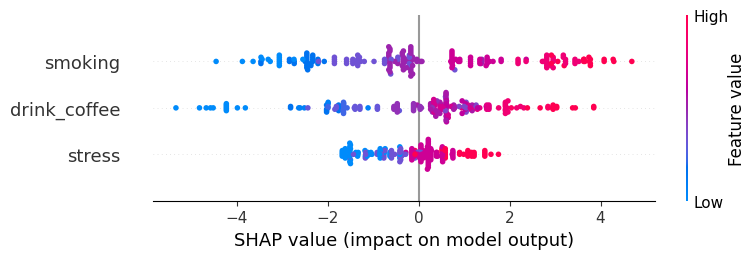

None
Index(['smoking', 'stress', 'drink_coffee'], dtype='object')
Average values for each column:
Column 0: 1.7688
Column 1: 0.6727
Column 2: 1.4106


In [3]:
# Tree SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
print(shap.summary_plot(shap_values, X_test))

column_averages = np.mean(np.abs(shap_values), axis=0)
print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


Global SHAP Score:


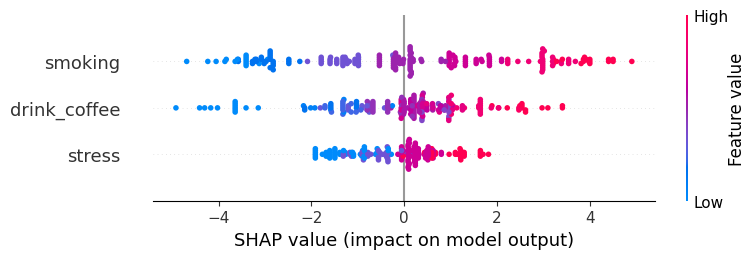

None
Index(['smoking', 'stress', 'drink_coffee'], dtype='object')
Average values for each column:
Column 0: 1.9127
Column 1: 0.6961
Column 2: 1.1015


In [38]:
# Kernel SHAP
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
print(shap.summary_plot(shap_values, X_test))

column_averages = np.mean(np.abs(shap_values), axis=0)
print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

Global SHAP Score:


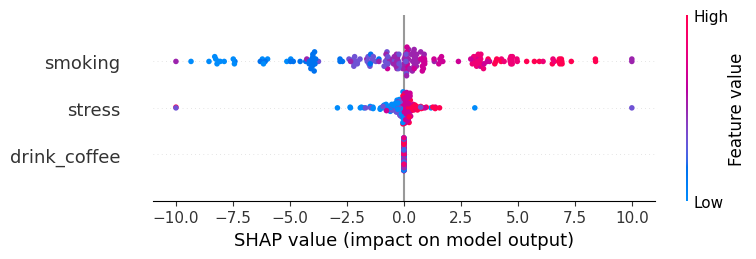

None
Index(['smoking', 'stress', 'drink_coffee'], dtype='object')
Average values for each column:
Column 0: 2.9134
Column 1: 0.5755
Column 2: 0.0000


In [49]:
# Causal SHAP
import pickle

file_path = '../../../result/R/Causal_SHAP_LC_42_Dec.pkl'
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

# Usage
data_path = '../../../dataset/Synthetic_LC_Dec.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']
feature_names = X.columns.tolist()

causal_shap_values = load_and_format_shap_values(file_path, feature_names)
causal_shap_values = np.clip(causal_shap_values, -10, 10)  

print("Global SHAP Score:")
print(shap.summary_plot(causal_shap_values, X_test))

column_averages = np.mean(np.abs(causal_shap_values), axis=0)
print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

## Eval

In [5]:
import logging

# Set logging level to WARNING or ERROR
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)



In [47]:
import pickle

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

def evaluate_global_rmse_synthetic(full_shap_values, reduced_shap_values, feature_subset_list):
    """
    Evaluate SHAP values by comparing attributions with and without intermediary features.
    """
        
    feature_indices = [list(X_test.columns).index(f) for f in feature_subset_list]
    
    if isinstance(full_shap_values, list):
        full_importance = pd.Series({
            feature: np.abs(full_shap_values[:, idx]).mean() 
            for feature, idx in zip(feature_subset_list, feature_indices)
        })
    else:
        full_values = full_shap_values[:, feature_indices]
        full_importance = pd.Series(
            np.abs(full_values).mean(axis=0),
            index=feature_subset_list
        )
    
    if hasattr(reduced_shap_values, 'values'):
        reduced_values = reduced_shap_values.values
    else:
        reduced_values = reduced_shap_values
        
    if isinstance(reduced_values, list):
        reduced_importance = pd.Series({
            feature: np.abs(values).mean() 
            for feature, values in zip(feature_subset_list, np.array(reduced_values).T)
        })
    else:
        reduced_importance = pd.Series(
            np.abs(reduced_values).mean(axis=0),
            index=feature_subset_list
        )
    
    squared_diff_sum = 0
    for feature in feature_subset_list:
        squared_diff_sum += (full_importance[feature] - reduced_importance[feature]) ** 2
    
    rmse = np.sqrt(squared_diff_sum / len(feature_subset_list))
    
    return rmse

In [51]:
seeds = [42, 123, 456, 789, 1010]
results = {
    'kernel': [],
    'tree': [],
    'causal': []
}

data_path = '../../../dataset/Synthetic_LC.csv'
df = pd.read_csv(data_path)

for seed in seeds:
    print(f"\nProcessing seed: {seed}")
    
    # Exact SHAP
    X = df.drop(columns=['lung_cancer_risk','air_quality_index','age','smoking'])
    y = df['lung_cancer_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    explainer = shap.ExactExplainer(rf.predict, X_test)
    exact_reduced_shap_values = explainer(X_test[:])

    # Kernel SHAP
    X = df.drop(columns=['lung_cancer_risk'])
    y = df['lung_cancer_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    rf.fit(X_train, y_train)

    background_data = shap.kmeans(X_train, 100)
    explainer = shap.KernelExplainer(rf.predict, background_data)
    kernel_shap_values = explainer.shap_values(X_test)

    # Tree SHAP
    explainer = shap.TreeExplainer(rf)
    tree_shap_values = explainer.shap_values(X_test)

    # Causal SHAP
    causal_shap_values = load_and_format_shap_values(
        f'../../../result/SyntheticLC/Causal_SHAP_LC_{seed}.pkl', 
        X.columns.tolist()
    )

    # Evaluation
    feature_subset = ['industrial_activity', 'air_pollution_exposure']

    rmse_kernel = evaluate_global_rmse_synthetic(
        kernel_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    rmse_tree = evaluate_global_rmse_synthetic(
        tree_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    rmse_causal = evaluate_global_rmse_synthetic(
        causal_shap_values,
        exact_reduced_shap_values,
        feature_subset
    )

    # Store results
    results['kernel'].append(rmse_kernel)
    results['tree'].append(rmse_tree)
    results['causal'].append(rmse_causal)
    
    print(f"Seed {seed} Results:")
    print(f"Kernel SHAP RMSE: {rmse_kernel:.4f}")
    print(f"Tree SHAP RMSE: {rmse_tree:.4f}")
    print(f"Causal SHAP RMSE: {rmse_causal:.4f}")

# Calculate and print means and standard deviations
print("\nFinal Results:")
for method in results:
    mean_rmse = np.mean(results[method])
    std_rmse = np.std(results[method])
    print(f"{method.capitalize()} SHAP - Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")


Processing seed: 42


ExactExplainer explainer: 201it [00:12,  2.73it/s]                         
100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


Seed 42 Results:
Kernel SHAP RMSE: 2.6171
Tree SHAP RMSE: 2.6262
Causal SHAP RMSE: 2.6443

Processing seed: 123


ExactExplainer explainer: 201it [00:13,  3.68it/s]                         
100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


Seed 123 Results:
Kernel SHAP RMSE: 2.2855
Tree SHAP RMSE: 2.3101
Causal SHAP RMSE: 1.9557

Processing seed: 456


ExactExplainer explainer: 201it [00:12,  3.17it/s]                         
100%|██████████| 200/200 [00:16<00:00, 12.12it/s]


Seed 456 Results:
Kernel SHAP RMSE: 2.6626
Tree SHAP RMSE: 2.6756
Causal SHAP RMSE: 2.2418

Processing seed: 789


ExactExplainer explainer: 201it [00:12,  2.83it/s]                         
100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


Seed 789 Results:
Kernel SHAP RMSE: 2.4979
Tree SHAP RMSE: 2.5208
Causal SHAP RMSE: 2.6040

Processing seed: 1010


ExactExplainer explainer: 201it [00:12,  2.87it/s]                         
100%|██████████| 200/200 [00:16<00:00, 12.09it/s]


Seed 1010 Results:
Kernel SHAP RMSE: 2.3051
Tree SHAP RMSE: 2.3349
Causal SHAP RMSE: 2.2819

Final Results:
Kernel SHAP - Mean RMSE: 2.4736 ± 0.1554
Tree SHAP - Mean RMSE: 2.4935 ± 0.1485
Causal SHAP - Mean RMSE: 2.3455 ± 0.2541


### Synthetic LC Kernel SHAP Experiment

In [53]:
from evaluation import evaluate_global_shap_scores

data_path = '../../../dataset/Synthetic_LC.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']
feature_names = X.columns.tolist()

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['lung_cancer_risk'])
    y = df['lung_cancer_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    background_data = shap.kmeans(X_train, 100)
    explainer = shap.KernelExplainer(rf.predict, background_data)
    kernel_shap_values = explainer.shap_values(X_test)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(kernel_shap_values).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


100%|██████████| 200/200 [00:17<00:00, 11.61it/s]
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.41273527593895,
                24.217344866040467,
                23.472996346865827,
                24.65504324484444,
                24.77963150872433
            ],
            "mae": [
                18.896788287382083,
                20.7751701721895,
                19.976200190476593,
                21.230353404965175,
                21.366202060799896
            ],
            "r_squared": [
                -2.067347358209233,
                -2.581181147421877,
                -2.364420721732879,
                -2.7118017659197617,
                -2.749409922988079
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 23.9075502484828,
            "mae": 20.448942823162646,
            "r_squ

100%|██████████| 200/200 [00:17<00:00, 11.53it/s]
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                23.12990148186462,
                25.244380556589274,
                25.770871361117383,
                26.068921652231314,
                26.508866652515394
            ],
            "mae": [
                20.11037565203159,
                22.25373743875668,
                22.85329617948356,
                23.207710581321148,
                23.671002476167885
            ],
            "r_squared": [
                -2.5870090149413323,
                -3.2728174560633887,
                -3.4529017046895722,
                -3.5564964462689934,
                -3.7115870913064626
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 25.3445883408636,
            "mae": 22.419224465552173,
            "

100%|██████████| 200/200 [00:16<00:00, 11.90it/s]
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.952521547526477,
                25.051488215968384,
                26.95265560181226,
                26.321879336597657,
                26.117332194005353
            ],
            "mae": [
                20.29633667854066,
                22.297487175227342,
                24.251158395311496,
                23.619732836234842,
                23.42783306915487
            ],
            "r_squared": [
                -2.7422033402826003,
                -3.4579340173494337,
                -4.160237594774228,
                -3.9215325567720027,
                -3.8453393688837965
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 25.479175379182028,
            "mae": 22.778509630893844,
           

100%|██████████| 200/200 [00:17<00:00, 11.53it/s]
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.136880272400123,
                24.45802656712696,
                25.273122428514878,
                25.99506230955573,
                25.97436012736258
            ],
            "mae": [
                18.36477215283453,
                20.65708465136272,
                21.433522471108144,
                22.21111792499892,
                22.215747305594792
            ],
            "r_squared": [
                -1.4101601926927412,
                -1.9420896459338532,
                -2.141455261584582,
                -2.323493259712628,
                -2.318201780510906
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 24.767490340992055,
            "mae": 20.97644890117982,
            "r_sq

100%|██████████| 200/200 [00:16<00:00, 11.85it/s]
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                20.032782745437725,
                21.58874860343218,
                23.058345247408802,
                23.629258175100407,
                23.97127959470752
            ],
            "mae": [
                17.27843618733277,
                18.83142769917725,
                20.283636969749974,
                20.843100348837524,
                21.17524901615795
            ],
            "r_squared": [
                -1.746447565690533,
                -2.1896548276960974,
                -2.638689727527124,
                -2.821104584988629,
                -2.9325222144734555
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 22.45608287321733,
            "mae": 19.682370044251094,
            "r_s

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [54]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 24.390977436547562,
            "std": 1.1147043826739584
        },
        "mae": {
            "mean": 21.261099173007914,
            "std": 1.1727572695799737
        },
        "r_squared": {
            "mean": -2.7858415427365677,
            "std": 0.5914537915513283
        }
    },
    "insertion": {
        "rmse": {
            "mean": 10.285716785858934,
            "std": 0.5877530236821916
        },
        "mae": {
            "mean": 8.05049045151505,
            "std": 0.40233745253298564
        },
        "r_squared": {
            "mean": 0.3360421894861978,
            "std": 0.035981187834970396
        }
    }
}


### Synthetic LC Tree SHAP Experiment

In [55]:
from evaluation import evaluate_global_shap_scores

data_path = '../../../dataset/Synthetic_LC.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']
feature_names = X.columns.tolist()

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['lung_cancer_risk'])
    y = df['lung_cancer_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    explainer = shap.TreeExplainer(rf)
    tree_shap_values = explainer.shap_values(X_test)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(tree_shap_values).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.41273527593895,
                24.217344866040467,
                23.472996346865823,
                24.65504324484444,
                24.77963150872433
            ],
            "mae": [
                18.896788287382083,
                20.7751701721895,
                19.976200190476593,
                21.230353404965182,
                21.366202060799896
            ],
            "r_squared": [
                -2.067347358209233,
                -2.581181147421877,
                -2.3644207217328788,
                -2.7118017659197617,
                -2.749409922988079
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 23.9075502484828,
            "mae": 20.44894282316265,
            "r_squ

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                23.12990148186462,
                25.244380556589274,
                25.770871361117383,
                26.068921652231314,
                26.508866652515394
            ],
            "mae": [
                20.110375652031586,
                22.25373743875668,
                22.85329617948356,
                23.207710581321148,
                23.671002476167885
            ],
            "r_squared": [
                -2.5870090149413323,
                -3.2728174560633887,
                -3.4529017046895722,
                -3.5564964462689934,
                -3.7115870913064626
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 25.3445883408636,
            "mae": 22.419224465552173,
            

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.952521547526477,
                25.051488215968384,
                26.95265560181226,
                26.321879336597657,
                26.117332194005353
            ],
            "mae": [
                20.29633667854066,
                22.297487175227342,
                24.251158395311496,
                23.619732836234842,
                23.42783306915487
            ],
            "r_squared": [
                -2.7422033402826003,
                -3.4579340173494337,
                -4.160237594774228,
                -3.9215325567720027,
                -3.8453393688837965
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 25.479175379182028,
            "mae": 22.778509630893844,
           

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.136880272400123,
                24.45802656712696,
                25.273122428514878,
                25.99506230955573,
                25.974360127362576
            ],
            "mae": [
                18.36477215283453,
                20.65708465136272,
                21.433522471108144,
                22.21111792499892,
                22.215747305594792
            ],
            "r_squared": [
                -1.4101601926927412,
                -1.9420896459338532,
                -2.141455261584582,
                -2.323493259712628,
                -2.318201780510905
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 24.767490340992055,
            "mae": 20.97644890117982,
            "r_s

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [56]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 24.390977436547562,
            "std": 1.1147043826739584
        },
        "mae": {
            "mean": 21.261099173007914,
            "std": 1.1727572695799733
        },
        "r_squared": {
            "mean": -2.7858415427365677,
            "std": 0.5914537915513284
        }
    },
    "insertion": {
        "rmse": {
            "mean": 10.285716785858934,
            "std": 0.5877530236821916
        },
        "mae": {
            "mean": 8.05049045151505,
            "std": 0.40233745253298564
        },
        "r_squared": {
            "mean": 0.3360421894861978,
            "std": 0.03598118783497037
        }
    }
}


### Synthetic LC Causal SHAP Experiment

In [58]:
import pickle

file_paths = ['../../../result/SyntheticLC/Causal_SHAP_LC_42.pkl', '../../../result/SyntheticLC/Causal_SHAP_LC_123.pkl', '../../../result/SyntheticLC/Causal_SHAP_LC_456.pkl', '../../../result/SyntheticLC/Causal_SHAP_LC_789.pkl', '../../../result/SyntheticLC/Causal_SHAP_LC_1010.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

# Usage
data_path = '../../../dataset/Synthetic_LC.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']
feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

In [59]:
from evaluation import evaluate_global_shap_scores

seeds = [42, 123, 456, 789, 1010]
# Rerun 42, 123
all_scores = {
    'deletion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    },
    'insertion': {
        'rmse': [],
        'mae': [],
        'r_squared': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")

    X = df.drop(columns=['lung_cancer_risk'])
    y = df['lung_cancer_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    rf.fit(X_train, y_train)

    result = evaluate_global_shap_scores(rf, X_test, y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['rmse', 'mae', 'r_squared']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1

Training Random Forest model...


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.41273527593895,
                21.840011881699958,
                23.804722977551144,
                23.229767312295536,
                24.77963150872433
            ],
            "mae": [
                18.896788287382083,
                18.38754325481842,
                20.384570076594795,
                19.761291961838634,
                21.366202060799896
            ],
            "r_squared": [
                -2.067347358209233,
                -1.9125874738890403,
                -2.4601864448857333,
                -2.2950571842440675,
                -2.749409922988079
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 23.21337379124198,
            "mae": 19.759279128286767,
            "

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                23.12990148186462,
                22.696993659694556,
                25.19449032790515,
                26.054082006036168,
                26.508866652515394
            ],
            "mae": [
                20.110375652031586,
                19.703408073160105,
                22.207447299832758,
                23.17183129617986,
                23.671002476167885
            ],
            "r_squared": [
                -2.5870090149413323,
                -2.4539939688408188,
                -3.255945487682678,
                -3.551310382132015,
                -3.7115870913064626
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 24.716866825603176,
            "mae": 21.77281295947444,
            "

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.952521547526477,
                21.41634921284533,
                23.79010877992504,
                23.901065217629068,
                26.117332194005353
            ],
            "mae": [
                20.29633667854066,
                18.849259053574045,
                21.106426786054495,
                21.221895251961445,
                23.42783306915487
            ],
            "r_squared": [
                -2.7422033402826003,
                -2.2580478181861467,
                -3.020308963829274,
                -3.0578976454055375,
                -3.8453393688837965
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 23.635475390386254,
            "mae": 20.980350167857104,
            

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [],
            "cross_entropy": [],
            "brier": [],
            "rmse": [
                22.136880272400123,
                21.722930607168074,
                23.944376579676845,
                24.753101519571107,
                25.97436012736258
            ],
            "mae": [
                18.364772152834526,
                18.028542955924273,
                20.186273792568667,
                20.94544712631634,
                22.215747305594792
            ],
            "r_squared": [
                -1.4101601926927412,
                -1.3208651463073378,
                -1.8198119397275838,
                -2.01350782012838,
                -2.318201780510906
            ]
        },
        "average_scores": {
            "auroc": NaN,
            "cross_entropy": NaN,
            "brier": NaN,
            "rmse": 23.706329821235745,
            "mae": 19.94815666664772,
            "

c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [60]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "rmse": {
            "mean": 23.47732321675868,
            "std": 0.8415092900578002
        },
        "mae": {
            "mean": 20.359334005081145,
            "std": 0.8899194855982504
        },
        "r_squared": {
            "mean": -2.506640146253004,
            "std": 0.48840870202636666
        }
    },
    "insertion": {
        "rmse": {
            "mean": 10.337876507592716,
            "std": 0.5492652721844937
        },
        "mae": {
            "mean": 8.068274347177024,
            "std": 0.323724763125933
        },
        "r_squared": {
            "mean": 0.32874662278837513,
            "std": 0.03306869012832899
        }
    }
}


In [3]:
from causal_inference import CausalInference

base_dir = '../../'
result_dir = base_dir + 'result/R/'

print("Starting ML Pipeline...")
print(f"Base directory set to: {base_dir}")

    # Define base directory and result directory
print("Loading data...")
data_path = '../../../dataset/Synthetic_LC.csv'
df = pd.read_csv(data_path)
print("Data loaded successfully.")

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Random Forest model...")
rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
rf.fit(X_train, y_train)
print("Model Trained Successfully!")

    # Initialize CausalInference
ci = CausalInference(data=X_train, model=rf, target_variable='lung_cancer_risk')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_LC.json')

DEBUG:pydot:pydot initializing
DEBUG:pydot:pydot 3.0.2
DEBUG:pydot.dot_parser:pydot dot_parser module initializing
DEBUG:pydot.core:pydot core module initializing


Starting ML Pipeline...
Base directory set to: ../../../
Loading data...
Data loaded successfully.
Training Random Forest model...
Model Trained Successfully!


{'age': 0.13643884445006318,
 'smoking': 0.07151424707022415,
 'air_pollution_exposure': 0.23286164471193085,
 'air_quality_index': 0.47219711182700996,
 'industrial_activity': 0.08698815194077178}

In [4]:
print(ci.gamma)

{'age': 0.13643884445006318, 'smoking': 0.07151424707022415, 'air_pollution_exposure': 0.23286164471193085, 'air_quality_index': 0.47219711182700996, 'industrial_activity': 0.08698815194077178}
